# 🌱 Analysis of Experimental Conditions (G, C, S) on Soybean Productivity

This section explores how different **genotypes (G)**, **salicylic acid levels (C)**, and **water stress (S)** conditions affect soybean **productivity**, and identifies the optimal combinations for **maximum seed yield** using:

- Exploratory Data Analysis (EDA)
- Statistical Testing (ANOVA)
- Predictive Modeling (Random Forest)
- Feature Importance via SHAP


 1. Load Dataset + Preprocess


In [3]:
# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import f_oneway

c:\Users\utkar\.conda\envs\AI_Lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 📥 Load dataset
df = pd.read_csv("3_direct_encoded.csv").drop_duplicates()

# ✅ Ensure correct data types
df['G'] = df['G'].astype(str)
df['C'] = df['C'].astype(str)
df['S'] = df['S'].astype(str)

# 🎯 Key output features to study
target_vars = ["Seed Yield per Unit Area (SYUA)", "Protein Content (PCO)",
               "Protein Percentage (PPE)", "Sugars (Su)", "Number of Pods (NP)"]

Visual Analysis: Boxplots by G, C, S

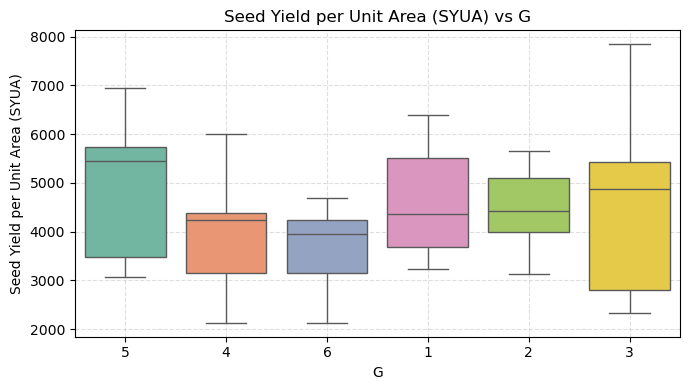

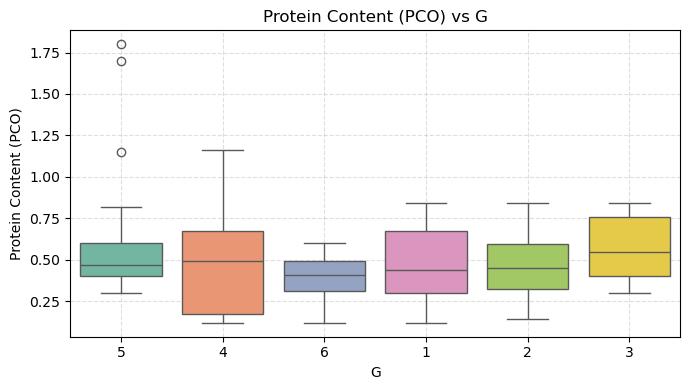

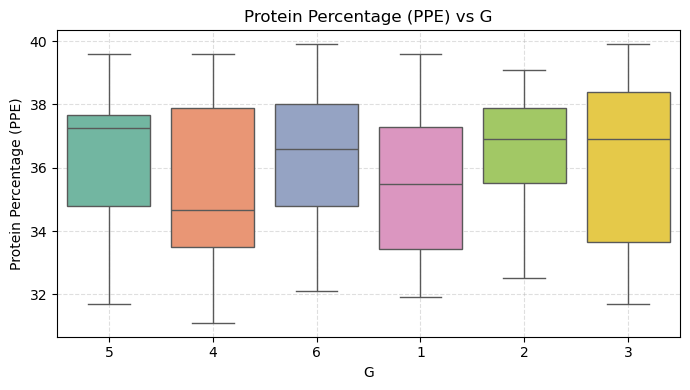

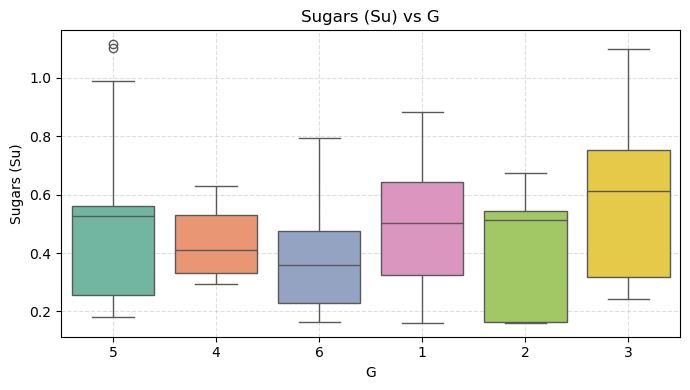

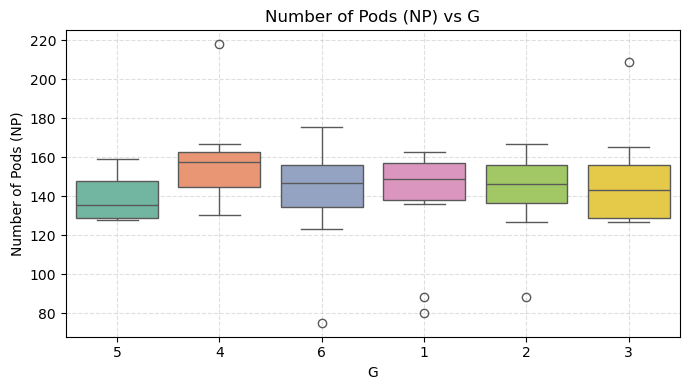

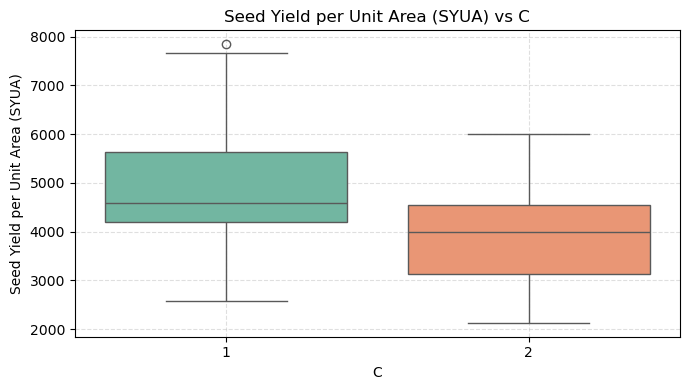

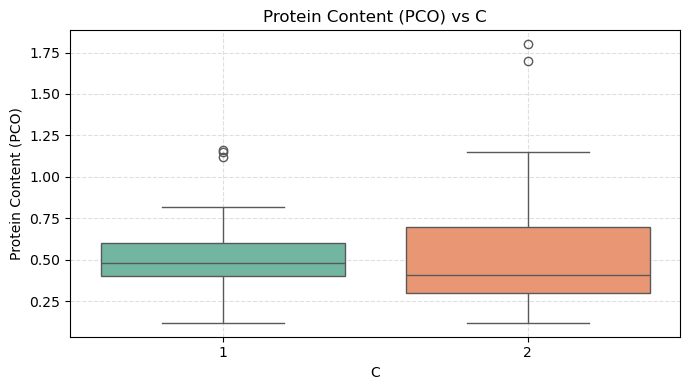

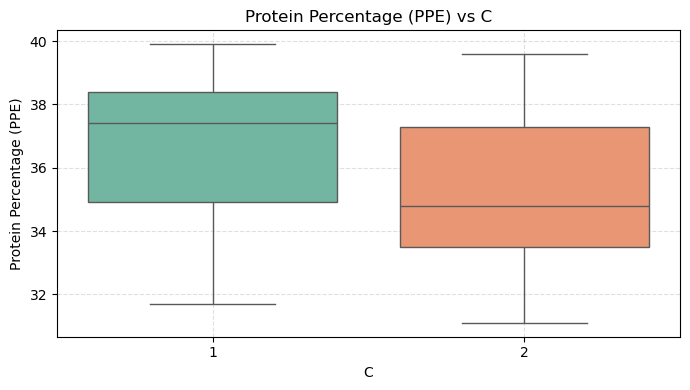

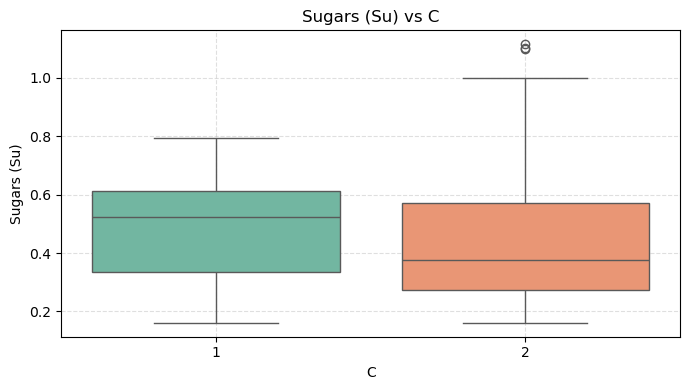

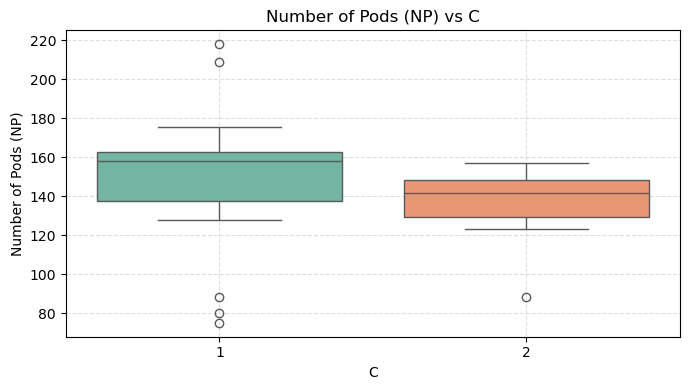

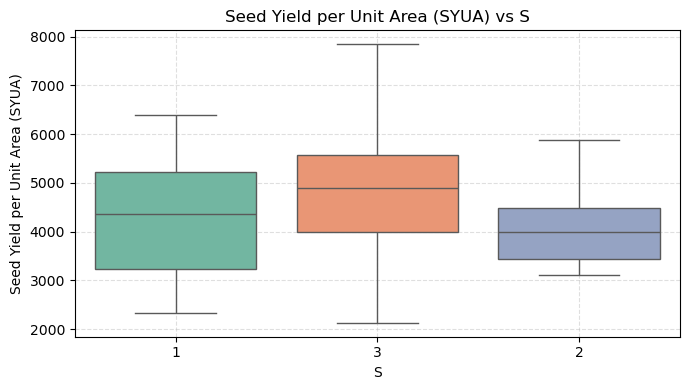

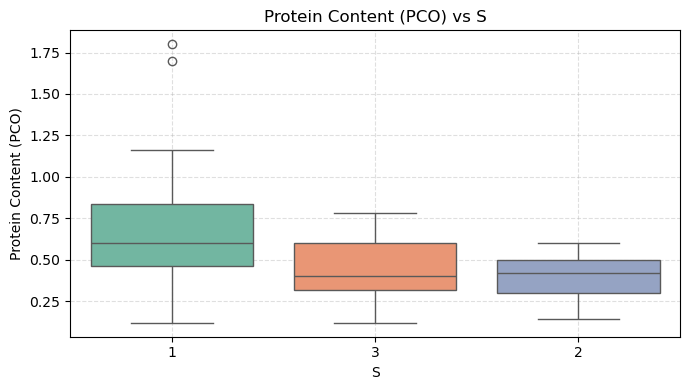

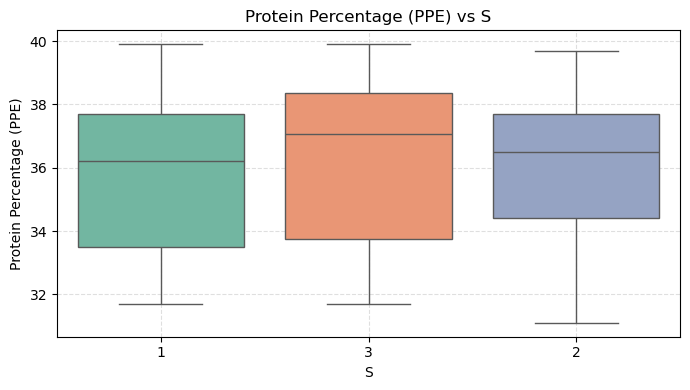

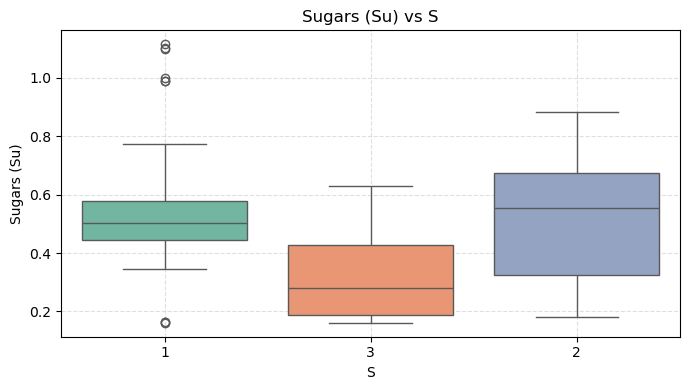

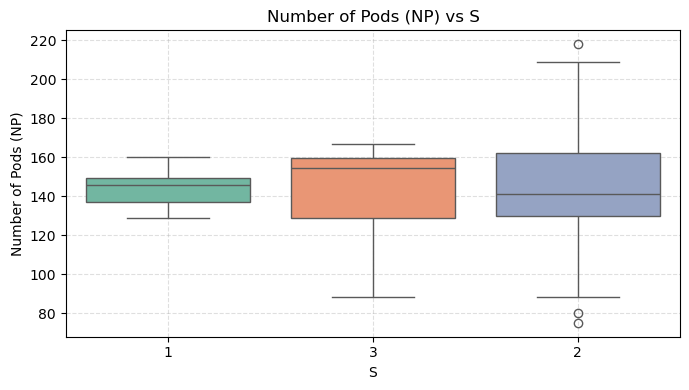

In [6]:
# 📈 Boxplots to visualize effect of G, C, S on target traits
for cat_var in ['G', 'C', 'S']:
    for target in target_vars:
        plt.figure(figsize=(7, 4))
        sns.boxplot(data=df, x=cat_var, y=target, palette="Set2")
        plt.title(f"{target} vs {cat_var}")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

3. Statistical Analysis: ANOVA for G, C, S

In [ ]:
# 📐 One-Way ANOVA to test significance of categorical variables
for cat_var in ['G', 'C', 'S']:
    print(f"\n🔍 ANOVA for {cat_var} on SYUA:")
    groups = [group["Seed Yield per Unit Area (SYUA)"].values for name, group in df.groupby(cat_var)]
    stat, p = f_oneway(*groups)
    print(f"F-Statistic = {stat:.3f}, p-value = {p:.6f}")


🔍 ANOVA for G on SYUA:
F-Statistic = 3.104, p-value = 0.011939

🔍 ANOVA for C on SYUA:
F-Statistic = 18.829, p-value = 0.000033

🔍 ANOVA for S on SYUA:
F-Statistic = 2.714, p-value = 0.070940


4. Combined Effects: Group by G+C+S

In [16]:
# 📊 Mean SYUA grouped by genotype + salicylic + water stress
combo_group = df.groupby(["G", "C", "S"])[["Seed Yield per Unit Area (SYUA)"] + target_vars].mean().reset_index()
# Drop the duplicate column if it's not needed
combo_group = combo_group.loc[:, ~combo_group.columns.duplicated()]

# Now sort by the remaining "Seed Yield per Unit Area (SYUA)"
combo_group_sorted = combo_group.sort_values("Seed Yield per Unit Area (SYUA)", ascending=False)

# 🥇 Top 10 combinations
print("🏆 Top 10 G+C+S combinations by average yield:")
print(combo_group_sorted.head(10))


🏆 Top 10 G+C+S combinations by average yield:
    G  C  S  Seed Yield per Unit Area (SYUA)  Protein Content (PCO)  \
14  3  1  3                      7640.566667               0.573333   
25  5  1  3                      6785.200000               0.473333   
0   1  1  1                      6320.466667               0.140000   
24  5  1  2                      5667.300000               0.430000   
2   1  1  3                      5594.500000               0.333333   
23  5  1  1                      5560.233333               0.673333   
28  5  2  3                      5491.166667               0.353333   
20  4  2  1                      5439.233333               0.600000   
8   2  1  3                      5408.500000               0.356667   
16  3  2  3                      5144.433333               0.380000   

    Protein Percentage (PPE)  Sugars (Su)  Number of Pods (NP)  
14                 35.200000     0.244667           164.000000  
25                 35.233333     0.538333 

5. Predictive Modeling: Yield Estimation

In [17]:
# ⚙️ Select features for modeling (encoded)
model_df = df.copy()
enc = LabelEncoder()
model_df["G_enc"] = enc.fit_transform(model_df["G"])
model_df["C_enc"] = enc.fit_transform(model_df["C"])
model_df["S_enc"] = enc.fit_transform(model_df["S"])

feature_cols = ["G_enc", "C_enc", "S_enc", 
                "Plant Height (PH)", "Number of Pods (NP)", "Leaf Area Index (LAI)",
                "Biological Weight (BW)", "Sugars (Su)", "Protein Content (PCO)",
                "ChlorophyllA663", "Chlorophyllb649", "Relative Water Content in Leaves (RWCL)",
                "Protein Percentage (PPE)", "Weight of 300 Seeds (W3S)",
                "Number of Seeds per Pod (NSP)"]

X = model_df[feature_cols]
y = model_df["Seed Yield per Unit Area (SYUA)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
# 📊 Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("🎯 R2 Score on test set:", r2_score(y_test, y_pred))

🎯 R2 Score on test set: 0.5495566441838059


 6. SHAP Interpretability for Yield Prediction

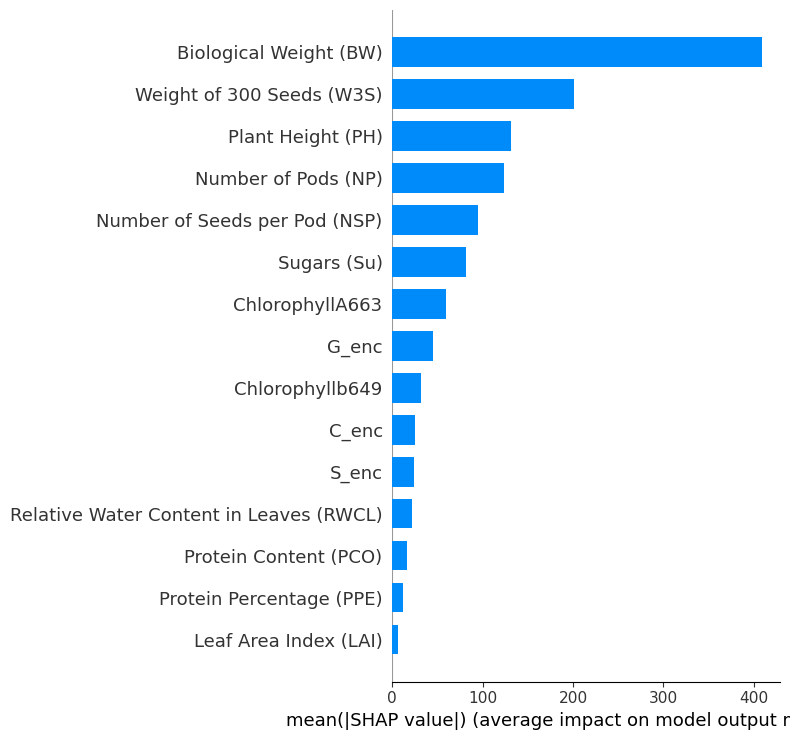

In [20]:
# 🔍 SHAP Explainability
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)

# 📊 SHAP Summary Plot
shap.summary_plot(shap_values, X, plot_type="bar", show=True)

 7. Find Optimal Growing Conditions

In [21]:
# 💡 Add predicted yield for each row
X["Predicted_Yield"] = model.predict(X)

# 🏆 Attach G, C, S back
X["G"] = df["G"]
X["C"] = df["C"]
X["S"] = df["S"]

# 📋 Top 10 rows with highest predicted yield
top_conditions = X.sort_values("Predicted_Yield", ascending=False).head(10)
top_conditions[["G", "C", "S", "Predicted_Yield"] + feature_cols[:5]]  # top + some features


,G,C,S,Predicted_Yield,G_enc,C_enc,S_enc,Plant Height (PH),Number of Pods (NP)
99,3,1,3,7609.954,2,0,2,54.2,165.0
65,3,1,3,7503.341,2,0,2,55.2,164.0
97,3,1,3,7420.106,2,0,2,53.2,163.0
55,5,1,3,6413.789,4,0,2,50.0,159.0
46,5,1,3,6339.768,4,0,2,52.1,158.0
7,5,1,3,6268.419,4,0,2,52.0,158.3
3,1,1,1,5902.558,0,0,0,50.5,140.8
43,1,1,1,5837.364,0,0,0,49.5,141.0
17,1,1,1,5746.798,0,0,0,51.0,142.0
91,3,2,1,5720.348,2,1,0,50.4,156.0


In [ ]:
# combo_group_sorted.to_csv("GCS_combinations_ranked_by_yield.csv", index=False)
# top_conditions.to_csv("top_conditions_predicted_yield.csv", index=False)